In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Property Assessment 2018
- Data is pulled from City of Edmonton Open Data portal.

- `nb` stands for neighbourhood

### Set the correct data types for each of the remaining columns and reorder columns

In [2]:
col_names = ['acc_num', 'suite', 'number', 'street', 'value', 'class', 
             'nb_id', 'nb', 'ward', 'garage', 'lat', 'long']
col_dtypes = {'acc_num':np.int32, 'suite':object, 'number':object, 'street':object, 
              'value':np.int32, 'class':'category', 'nb':'category'}
col_keep = ['acc_num', 'nb', 'class', 'value', 'suite', 'number', 'street',
             'garage']

df = pd.read_csv('Property_Assessment_Data__Current_Calendar_Year_.csv', 
                 header=0, names=col_names, dtype=col_dtypes, 
                 true_values='Y', false_values='N')[col_keep]

# Property Information 2018

In [3]:
col_names = ['acc_num', 'suite', 'number', 'street', 'legal_desc', 'zoning', 
             'lot_size', 'year_built', 'nb_id', 'nb', 'ward', 'lat', 'long']
col_dtypes = {'acc_num':np.int32, 'zoning':object, 'lot_size':object, 'year_built':object}
col_keep = ['acc_num', 'zoning', 'lot_size', 'year_built', 'nb']

df_info = pd.read_csv('Property_Information_Data__Current_Calendar_Year_.csv', 
                 header=0, names=col_names, dtype=col_dtypes, low_memory=False)[col_keep]

### Remove and verify the number of null neighbourhood ID records
- This dataset contains one record without a neighbourhood ID.
    - This record has a substantially lower property assessment value.
    - This record represents an outlier in the nearly 400,000 records

In [4]:
df_null = df[df.nb.isnull()]
df_info_null = df_info[df_info.nb.isnull()]

df_cleaned = df[~df.nb.isnull()]
df_info_cleaned = df_info[~df_info.nb.isnull()]
print('The number of null neighbourhood records in df = {}'.format(len(df_null)))
print('The number of null neighbourhood records in df_info = {}'.format(len(df_info_null)))

The number of null neighbourhood records in df = 1
The number of null neighbourhood records in df_info = 1


## Merge the data and info DataFrames

In [5]:
df_info_cleaned = df_info_cleaned[['acc_num', 'zoning', 'lot_size', 'year_built']]

df_clean = df_cleaned.merge(df_info_cleaned, on='acc_num')

# Edmonton Criminal Incidents by Neibourhood
- Data is pulled from City of Edmonton Open Data portal.
- The two data frames will be joined on `nb` neighbourhood name.

### Rename the columns more logically and to align with `df_cleaned`

In [6]:
col_list = ['nb', 'violation', 'year', 'quarter', 'month', 'num_incidents']
col_dtypes = {'nb':'category', 'violation':'category', 'year':str, 'month':str}
col_order = ['nb', 'violation', 'num_incidents', 'year', 'month', 'quarter']

df_crim = pd.read_csv('EPS_Neighbourhood_Criminal_Incidents.csv', header=0, 
                      names=col_list, dtype=col_dtypes)[col_order]

### Convert `year` and `month` to a datetime column

In [7]:
datetime = pd.to_datetime(df_crim['year'] + '-' + df_crim['month'])

df_crim['record_month'] = datetime

df_crim_clean = df_crim[['nb', 'violation', 'num_incidents', 'record_month']]

### Pivot the table to provide a clean merge and representation of the total number of criminal incidents between 2009-2018 for each of the 8 violation categories

In [8]:
nb_incidents = df_crim.pivot_table(index='nb', values='num_incidents', columns='violation', aggfunc='sum')

### Merge the two dataframes to generate a complete and cleaned dataset
- Reset the index and drop the old index

In [9]:
property_assess = df_clean.merge(nb_incidents, left_on='nb', right_index=True)
property_assess.reset_index(inplace=True)
property_assess.drop('index', axis=1, inplace=True)
property_assess.head(1)

,acc_num,nb,class,value,suite,number,street,garage,zoning,lot_size,year_built,Assault,Break and Enter,Homicide,Robbery,Sexual Assaults,Theft From Vehicle,Theft Of Vehicle,Theft Over $5000
0,1315092,OLIVER,Residential,259000,1005,10011,123 STREET NW,False,DC1,NaN,1981,1314.0,973.0,8.0,295.0,151.0,1941.0,903.0,43.0


### Assessment of property outliers

Text(0,0.5,'Assessed Value in Trillions (CAD)')

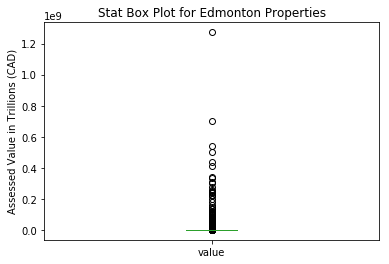

In [63]:
ax = property_assess['value'].plot(kind='box', title='Stat Box Plot for Edmonton Properties')
ax.set_ylabel('Assessed Value in Trillions (CAD)')

Text(0,0.5,'Assessed Value x 10 Billion (CAD)')

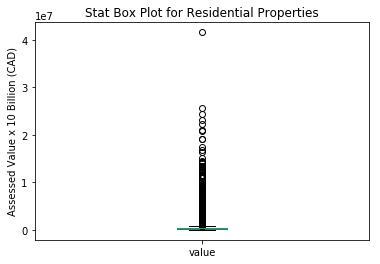

In [66]:
df_res = property_assess[property_assess['class'] == 'Residential']
ax = df_res['value'].plot(kind='box', title='Stat Box Plot for Residential Properties')
ax.set_ylabel('Assessed Value x 10 Billion (CAD)')

## Reshaping of data for analysis

In [10]:
df_grouped = df_cleaned.groupby(['nb']).mean()
df_grouped = df_grouped[['value']]

In [11]:
nb_incidents = df_crim.pivot_table(index='nb', values='num_incidents', 
                                   columns='violation', aggfunc='sum', fill_value=0)

neighbourhood_assess = df_grouped.merge(nb_incidents, left_on='nb', right_index=True)

nb_assess = neighbourhood_assess.reset_index()

## Example Analysis of Incident Type:

In [12]:
def incident_dist(incident, high_count):
    '''A function that takes an criminal incident designator,
    (Assault, Break and Enter, Homicide, Robbery, Sexual Assults, Theft From Vehicle,
    Theft Of Vehicle, Theft Over $5000) and returns a histogram distribution.
    high_count - is an int that represents the highest incident count for a neighbourhood
    '''
    
    print('The maximum number of ' + incident + ' for any neighbourhood in Edmonton is: \n' 
          + str(nb_assess[incident].max()))
    print('\nThe neighbourhoods with no ' + incident + ' is/are: \n' 
          + str(nb_assess[nb_assess[incident] == 0].nb))
    print('\nThe neighbourhood with the most ' + incident + ' is: \n' 
          + str(nb_assess[nb_assess[incident] == nb_assess[incident].max()].nb))
    
    ax = nb_assess[incident].plot(kind='hist',range=(0,high_count), bins=100, title=incident)
    ax.set_ylabel('Number of Neighbourhoods')
    ax.set_xlabel('Number of Incidents from 2009-18')
plt.show()

The maximum number of Theft Of Vehicle for any neighbourhood in Edmonton is: 
959

The neighbourhoods with no Theft Of Vehicle is/are: 
11         ANTHONY HENDAY CLAREVIEW
14     ANTHONY HENDAY LAKE DISTRICT
24                            ASTER
45            BLACKMUD CREEK RAVINE
229         MILL CREEK RAVINE SOUTH
279       RIVER VALLEY CAPITOL HILL
366     WHITEMUD CREEK RAVINE SOUTH
370                 WINDERMERE AREA
Name: nb, dtype: category
Categories (395, object): [ABBOTTSFIELD, ALBANY, ALBERTA AVENUE, ALBERTA PARK INDUSTRIAL, ..., MILL WOODS PARK, RIVER VALLEY LAURIER, RIVER VALLEY LESSARD NORTH, GLENRIDDING RAVINE]

The neighbourhood with the most Theft Of Vehicle is: 
104    DOWNTOWN
Name: nb, dtype: category
Categories (395, object): [ABBOTTSFIELD, ALBANY, ALBERTA AVENUE, ALBERTA PARK INDUSTRIAL, ..., MILL WOODS PARK, RIVER VALLEY LAURIER, RIVER VALLEY LESSARD NORTH, GLENRIDDING RAVINE]


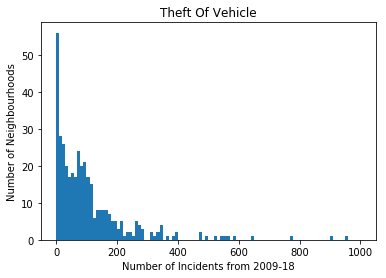

In [13]:
incident_dist('Theft Of Vehicle',1000)